# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [2]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

#Широкий набор специальных математических функций
from scipy import special

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [244]:
L1 = np.array([[1, 0], [10**20, 1]])
U1 = np.array([[10**-20, 1], [0, 1 - 10**-20]])
A1 = L1 * U1
L2 = np.array([[1., 0], [10.**20, 1.]])
U2 = np.array([[10.**-20, 1.], [0, 1. - 10.**-20]])
A2 = L2 * U2
print('A1.dtype =', A1.dtype)
print('A1:\n', A1)
print('A2.dtype =', A2.dtype)
print('A2:\n', A2)
print('A1 == A2:\n', A1 == A2)

A1.dtype = object
A1:
 [[1e-20 0.0]
 [0.0 1.0]]
A2.dtype = float64
A2:
 [[  1.00000000e-20   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00]]
A1 == A2:
 [[ True  True]
 [ True  True]]


**Ответ.** Изменился только тип матрицы. $10^{20}$ - это слишком много, чтобы хранить в любом стандартном типе, поэтому `dtype` первой матрицы `object`. А вот во второй матрице уже нет больших целых чисел, все числа в ней дробные, поэтому ее тип `float64`. В результате этого отличается маленько их вывод, хотя их произведение совпадает полностью.

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [197]:
import math


def get_cos_sin(x, y):
    denominator = math.sqrt(x**2 + y**2)
    return x / denominator, -y / denominator


def build_mat(x, y):
    cos_phi, sin_phi = get_cos_sin(x, y)
    return np.array([[cos_phi, -sin_phi],
                     [sin_phi, cos_phi]])


A = np.array([[10**-20, 1],
              [1, 1]])
I = np.array([[1, 0],
              [0, -1]])
Q = build_mat(A[0][0], A[1][0])
R = I.dot(Q.dot(A))
Q = Q.transpose().dot(I)
QR = Q.dot(R)
print('Q:\n', Q)
print('R:\n', R)
print('QR:\n', QR)
print('QR == A:\n', QR == A)


Q:
 [[  1.00000000e-20   1.00000000e+00]
 [  1.00000000e+00  -1.00000000e-20]]
R:
 [[ 1.  1.]
 [ 0.  1.]]
QR:
 [[  1.00000000e-20   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00]]
QR == A:
 [[ True  True]
 [ True  True]]


**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$

Но что, если это отношение велико?

**Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [248]:
import math


def gen_matrix(n):
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j or j == n - 1:
                mat[i][j] = 1
            if i > j:
                mat[i][j] = -1
    return mat


A = gen_matrix(500)
Q, R = sla.qr(A)
print('QR error =', sla.norm(A - Q.dot(R)))
P, L, U = sla.lu(A)
assert (P == np.eye(P.shape[0])).all()
print('PLU error =', sla.norm(A - L.dot(U)))
ro = abs(U).max() / abs(A).max()
print('factor =', ro)

QR error = 1.10327887978e-12
PLU error = 3.10251707042e+116
factor = 1.63669530395e+150


К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

**Ответ**

* $L_{nk} = C_{n}^{k}$, если $n \geq k$
* $L_{nk} = 0$, если $n < k$
* $R = L^{T}$

Ответ угадался, после вывода по формуле для небольшой матрицы. Проверить его можно напрямую с помощью свертки Вандермонда. Из нее следует, что $LU=A$. Достаточно просто для произвольных строк столбцов свернуть произведение.

Т.к. и $L$ и $R$ содержат единицы на главной диагонали ($C_{i}^{i}$), а также $A = LU$, поэтому определитель $A$ равен $1$.

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [295]:
def fact(n):
    ret = 1
    for i in range(1, n + 1):
        ret *= i
    return ret


def choose(n, k):
    return fact(n) // fact(k) // fact(n - k)


def my_pascal(n):
    ret = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ret[i][j] = choose(i + j, i)
    return ret


def get_l(n):
    ret = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1):
            ret[i][j] = choose(i, j)
    return ret


def get_r(n):
    return get_l(n).transpose()


A = my_pascal(30)
L = get_l(30)
U = get_r(30)
print('||A - LU||_2 =', sla.norm(A - L.dot(U)))
P, L2, U2 = sla.lu(A)
print('||A - PLU||_2 =', sla.norm(A - P.dot(L2).dot(U2)))

||A - LU||_2 = 9.79795897113
||A - PLU||_2 = 5.42968528072
2.8982776317e+25


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [299]:
print('A.det() = ', sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print('||x1 - x|| =', sla.norm(x1 - x))

A.det() =  1.0299188904699096e+48
||x1 - x|| = 236999.60255106888


/home/ec2-user/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.158005706474147e-23
  ' condition number: {}'.format(rcond), RuntimeWarning)


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [300]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print('||x2 - x|| =', sla.norm(x2 - x))

||x2 - x|| = 319988568.9800868


Объясните полученные неприятные результаты.

In [296]:
print('||A|| * ||A.inv()|| =', sla.norm(A) * sla.norm(sla.inv(A)))

||A|| * ||A.inv()|| = 2.8982776317e+25


**Ответ**:

Число обусловленности исходной матрицы очень большое (2.8982776317e+25). Поэтому такая относительная погрешность решения. Число обусловленности произведения не может быть меньше числа обусловленности исходной матрицы, поэтому разложения не помогают получить более точные решения.

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [138]:
import timeit


def rand_complex(*args):
    A_real = np.random.rand(*args) - 0.5
    A_imag = (np.random.rand(*args) - 0.5) * 1j
    return A_real + A_imag


def create_gramm_matrix(n):
    A = rand_complex(n, n)
    return A.dot(A.conj().transpose())


def naive_solve(A, b):
    return sla.inv(A).dot(b)


def standart_solve(A, b):
    return sla.solve(A, b)


def cho_impl_solve(A, b):
    n = A.shape[0]
    L = np.zeros((n, n)) * 1j
    for i in range(n):
        for j in range(i):
            L[i][j] = (A[i][j] - L[i].dot(L[j].transpose().conj())) / L[j][j]
        L[i][i] = np.sqrt(A[i][i] - L[i].dot(L[i].transpose().conj()))
    L_st = L.transpose().conj()
    y = sla.solve_triangular(L, b, lower=True)
    return sla.solve_triangular(L_st, y)


def cho_lib_solve(A, b):
    c = sla.cho_factor(A)
    return sla.cho_solve(c, b)


Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [137]:
A = create_gramm_matrix(100)
b = rand_complex(100, 30)

xn = naive_solve(A, b)
xs = standart_solve(A, b)
xcs = cho_lib_solve(A, b)
xci = cho_impl_solve(A, b)

X = np.array([xn, xs, xcs, xci])
for a in X:
    for b in X:
        assert sla.norm(a - b) < 1e-6
        
print('all errors are less than 1e-6')

all errors are less than 1e-6


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

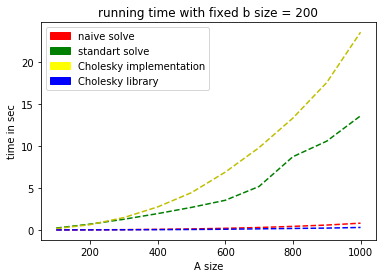

In [192]:
import matplotlib.patches as mpatches

A_sizes = np.array(range(100, 1001, 100))
b_size = 200
naive_times = []
standart_times = []
cho_impl_times = []
cho_lib_times = []
for a_size in A_sizes:
    A = create_gramm_matrix(a_size)
    b = rand_complex(a_size, b_size) 
    naive_times.append(timeit.timeit('naive_solve(A, b)',
                                     'from __main__ import A, b, naive_solve', number=10))
    standart_times.append(timeit.timeit('standart_solve(A, b)',
                                        'from __main__ import A, b, standart_solve', number=10))
    cho_impl_times.append(timeit.timeit('cho_impl_solve(A, b)',
                                        'from __main__ import A, b, cho_impl_solve', number=10))
    cho_lib_times.append(timeit.timeit('cho_lib_solve(A, b)',
                                        'from __main__ import A, b, cho_lib_solve', number=10))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('running time with fixed b size = 200')
ax.set_xlabel('A size')
ax.set_ylabel('time in sec')
red_patch = mpatches.Patch(color='red', label='naive solve')
ax.plot(A_sizes, naive_times, 'r--')
green_patch = mpatches.Patch(color='green', label='standart solve')
ax.plot(A_sizes, standart_times, 'g--')
blue_patch = mpatches.Patch(color='yellow', label='Cholesky implementation')
ax.plot(A_sizes, cho_impl_times, 'y--')
yellow_patch = mpatches.Patch(color='blue', label='Cholesky library')
ax.plot(A_sizes, cho_lib_times, 'b--')
ax.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.show()

Довольно интересный результат. Разложение Холецкого может не так сильно радует, все-таки оно накладывает не самые популярные ограничения на матрицу, а вот результат для квадратных матриц более чем радует. Умножение на обратную матрицу быстрее больше чем в 10 раз стандартного решателя.

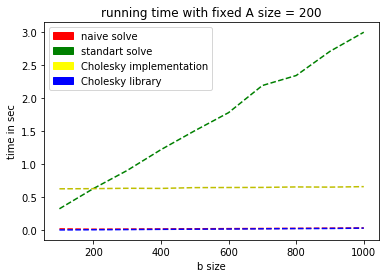

In [207]:
import matplotlib.patches as mpatches

a_size = 200
b_sizes = np.array(range(100, 1001, 100))
naive_times = []
standart_times = []
cho_impl_times = []
cho_lib_times = []
for b_size in b_sizes:
    A = create_gramm_matrix(a_size)
    b = rand_complex(a_size, b_size) 
    naive_times.append(timeit.timeit('naive_solve(A, b)',
                                     'from __main__ import A, b, naive_solve', number=10))
    standart_times.append(timeit.timeit('standart_solve(A, b)',
                                        'from __main__ import A, b, standart_solve', number=10))
    cho_impl_times.append(timeit.timeit('cho_impl_solve(A, b)',
                                        'from __main__ import A, b, cho_impl_solve', number=10))
    cho_lib_times.append(timeit.timeit('cho_lib_solve(A, b)',
                                        'from __main__ import A, b, cho_lib_solve', number=10))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('running time with fixed A size = 200')
ax.set_xlabel('b size')
ax.set_ylabel('time in sec')
red_patch = mpatches.Patch(color='red', label='naive solve')
ax.plot(b_sizes, naive_times, 'r--')
green_patch = mpatches.Patch(color='green', label='standart solve')
ax.plot(b_sizes, standart_times, 'g--')
blue_patch = mpatches.Patch(color='yellow', label='Cholesky implementation')
ax.plot(b_sizes, cho_impl_times, 'y--')
yellow_patch = mpatches.Patch(color='blue', label='Cholesky library')
ax.plot(b_sizes, cho_lib_times, 'b--')
ax.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.show()

Вполне логично, что время работы методов, которые основаны на преобразовании матрицы $A$ почти не меняются.

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [ ]:
#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Разреженные матрицы

Матрица называется разреженной, если в ней мало ненулевых элементов.

Например, если в матрице $n\times n$ порядка $O(n)$ ненулевых элементов, она является разреженной.

Зачастую размерность разреженных матриц, возникающих в реальных задачах, так велика, что хранить её в памяти вместе с нулями - непозволительная роскошь. Есть несколько экономичных методов хранения:

- `Dictionary of Keys` (`DOK`) - словарь `(i,j):element`. 

    $\color{green}{\oplus}$ быстрое добавление элементов с произвольными индексами,
  
    $\color{red}{\ominus}$ любые другие операции будут производиться медленно.


- `List of Lists` (`LIL`) - матрица хранится построчно: в виде двух массивов `[l_1,...,l_s]` и `[v_1,...v_s]`, где `l_i` - список номеров столбцов, в которых в i-й строке находится ненулевой элемент, а `v_i` - список соответствующих значений. В целом, подходит для создания в высокой степени разреженной матрицы. Когда все элементы добавлены, лучше перевести в формат `CSR` или `CSC`.

    $\color{green}{\oplus}$ добавление за линейное время, 
    
    $\color{green}{\oplus}$ быстрый доступ к строкам матрицы, 
    
    $\color{red}{\ominus}$ может требовать слишком много памяти (для создания матриц повышенной плотности используйте `COO`).

    
- `Coordinate List` (`COO`) - хранятся тройки `(row, column, value)`  или три массива \texttt{rows,\ columns,\ values}. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

    $\color{green}{\oplus}$ быстрое добавление новых элементов,
    
    $\color{red}{\ominus}$ для всего остального лучше перевести в другой формат.
    
    
- `Compressed Sparse Row/Column storage` (`CSR/CSC`) - разберём на примере `CSR`. Хранятся три массива: `values`, `indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные лексикографически по паре (строка, столбец); `indptr[i]` - индекс начала `i`-й строки, `indices[indptr[i]:indptr[i+1]-1]` - номера столбцов соответствующих элементов.

    $\color{green}{\oplus}$ быстрое выполнение арифметических операций,
    
    $\color{green}{\oplus}$ быстрый доступ к строкам для `CSR` и к столбцам для `CSC`,
    
    $\color{red}{\ominus}$ очень медленный доступ к столбцам для `CSR` и к строкам для `CSC`,
    
    $\color{red}{\ominus}$ медленное добавление/удаление элементов.
  

Главный вывод - не надо один и тот же формат использовать для разных целей!

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как эти возможности реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.0** Загрузите файл `sparse_matrix1.mtx`

In [2]:
import scipy.io as sio

In [3]:
A = sio.mmread(r'sparse_matrix1.mtx') # Please type right folder name! 

С помощью следующей функции можно посмотреть, как расположены ненулевые элементы матрицы:

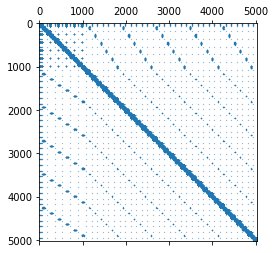

In [11]:
plt.spy(A, marker='.', markersize=0.4)

В каком из пяти форматов хранится матрица? Для ответа на этот вопрос воспользуйтесь функцию `type`.

Сколько в ней ненулевых элементов?


In [40]:
print(type(A))
print(A.count_nonzero())

<class 'scipy.sparse.coo.coo_matrix'>
94026


**Матрица хранится в формате `COO`.**

**В ней 94026 ненулевых элементов.**

Посмотрим, сколько времени занимает преобразование между разными форматами.

In [37]:
import pandas as pd
import timeit

A_dok = A.todok()
A_lil = A.tolil()
A_csc = A.tocsc()
A_csr = A.tocsr()

conversion_times = pd.DataFrame(
    index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    columns=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    data={
        'COO': [
            np.nan,
            timeit.timeit('A.todok()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tolil()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsr()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsc()', 'from __main__ import A', number=100) / 100,
               ],
        'DOK': [
            timeit.timeit('A_dok.tocoo()', 'from __main__ import A_dok', number=100) / 100,
            np.nan,
            timeit.timeit('A_dok.tolil()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsr()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsc()', 'from __main__ import A_dok', number=100) / 100,
               ],
        'LIL': [
            timeit.timeit('A_lil.tocoo()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.todok()', 'from __main__ import A_lil', number=100) / 100,
            np.nan,
            timeit.timeit('A_lil.tocsr()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.tocsc()', 'from __main__ import A_lil', number=100) / 100,
               ],
        'CSR': [
            timeit.timeit('A_csr.tocoo()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.todok()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.tolil()', 'from __main__ import A_csr', number=100) / 100,
            np.nan,
            timeit.timeit('A_csr.tocsc()', 'from __main__ import A_csr', number=100) / 100,
               ],
        'CSC': [
            timeit.timeit('A_csc.tocoo()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.todok()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tolil()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tocsr()', 'from __main__ import A_csc', number=100) / 100,
            np.nan,
               ],
    }
    )

conversion_times.T

COO       DOK       LIL       CSR       CSC
COO       NaN  0.025114  0.012697  0.000410  0.000453
DOK  0.012360       NaN  0.026076  0.012878  0.012761
LIL  0.009596  0.047050       NaN  0.009099  0.009548
CSR  0.000594  0.036701  0.011937       NaN  0.000439
CSC  0.000598  0.039042  0.012692  0.000436       NaN

Как вы можете убедиться, быстрее всего преобразования происходят между форматами `COO`, `CSR` и `CSC`, а хуже всего дела обстоят с форматом `DOK`: все преобразования из него занимают чудовищно много времени.

**Задание 3.1 (1 балл)** Почему преобразование из формата `LIL` и особенно `DOK` в формат `CSR` занимает такую пропасть времени?

----
**Ответ:**

* Для того, чтобы преобразовать матрицу из формата `DOK` в формат `CSR` нужно сначала пробежаться по словарю, что не быстро. Затем отсортировать элементы без какой-либо предварительной частичной отсортированности.

* Гораздо интереснее почему `COO` выигрывает так сильно у `LIL`. Оказалось, что `LIL` использует питоновские списки, а np.array --- это обертка на С-массивом, что разумеется быстрее.

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою список из нескольких сотен тысяч чеков (списков покупок). Для того, чтобы определить, какие товары чаще покупают вместе, вы решили построить матрицу, строки и столбцы которой соответствуют различным товарам (предположим, что число различных товаров тоже измеряется сотнями тысяч), а в клетке с "номером" $(g_1, g_2)$ стоит число

$\log_2{\frac{N\cdot c(g_1 \& g_2)}{c(g_1)c(g_2)}},$

где $c(g_i)$ --- количество чеков, содержащих товар $g_i$, $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара, $N$ --- общее число чеков. В каком формате вы будете создавать эту (очевидно разреженную) матрицу? Почему?

**Ответ:**

Задача распадается на две подзадачи: посчитать все кроме логарифма и взять логарифм каждого элемента в матрице. Из-за второго шага $COO$ не применима, ее все равно нужно будет приводить к другому типу. $LIL$ тоже кажется очень странным варинтом, трогать элемент за линее время от количества элементов в строке --- кажется долгим. Остается два варианта, попробовать суммировать в словарь, а потом сделать $DOK$ матрицу (а вдруг быстрее :)). Также можно попробовать собрать все записи повторного вхождения и заставить $CSR$ суммировать их. Второй вариант оказался сильно быстрее.

Напишите максимально эффективный код, создающий эту матрицу:

In [369]:
import random
import itertools
import timeit
import collections


def create_test(receipts_count, receipt_size, goods_count):
    return np.array([random.sample(range(goods_count), receipt_size)
            for i in range(receipts_count)])


def count_goods(receipts):
    goods_count = max(itertools.chain.from_iterable(receipts)) + 1
    count = np.array([0] * goods_count)
    for good in itertools.chain.from_iterable(receipts):
        count[good] += 1
    return count


def CreateCSRMatrix(receipts):
    single_count = count_goods(receipts)
    goods_count = len(single_count)
    row = []
    col = []
    data = []
    for receipt in receipts:
        for first_good in receipt:
            for second_good in receipt:
                if first_good == second_good:
                    continue
                x = n / single_count[first_good] / single_count[second_good]
                row.append(first_good)
                col.append(second_good)
                data.append(x)
    data = np.array(data)
    row = np.array(row)
    col = np.array(col)
    csr_matrix = sps.csc_matrix((data, np.array([row, col])))
    csr_matrix.data = np.log2(csr_matrix.data)
    return csr_matrix


def CreateDOKMatrix(receipts):
    single_count = count_goods(receipts)
    goods_count = len(single_count)
    d = collections.defaultdict(int)
    for receipt in receipts:
        for first_good in receipt:
            for second_good in receipt:
                if first_good == second_good:
                    continue
                x = n / single_count[first_good] / single_count[second_good]
                d[(first_good, second_good)] += x
    d = {k: np.log2(d[k]) for k in d}
    dok_matrix = sps.dok_matrix((goods_count, goods_count))
    dok_matrix.update(d)
    return dok_matrix

receipts = create_test(receipts_count=200000, receipt_size=5, goods_count=200000)
print('to CSR =', timeit.timeit('CreateCSRMatrix(receipts)',
                                'from __main__ import receipts, CreateCSRMatrix', number=5))
print('to DOK =', timeit.timeit('CreateDOKMatrix(receipts)',
                                'from __main__ import receipts, CreateDOKMatrix', number=5))


to CSR = 37.60537155298516
to DOK = 82.55474167922512


**Задание 3.3 (1 балл)** В каком из форматов `LIL` и `COO` умножение на вектор происходит быстрее? Почему? Проведите эксперименты. Можете воспользоваться функцией `scipy.sparse.random` для создания случайных разреженных матриц.

Насколько быстрее с аналогичной задачей будут справляться форматы `CSC` и `CSR`?

In [251]:
import pandas as pd
import timeit
import collections
import IPython.display

tests = [['n=1000, m=5000, d=0.1', 1000, 5000, 0.1],
         ['n=5000, m=1000, d=0.1', 5000, 1000, 0.1],
         ['n=5000, m=5000, d=0.1', 5000, 5000, 0.1],
         ['n=5000, m=5000, d=0.05', 5000, 5000, 0.05],
         ['n=5000, m=5000, d=0.01', 5000, 5000, 0.01]]

matrixes = [['COO', sps.coo_matrix],
            ['LIL', sps.lil_matrix],
            ['CSR', sps.csr_matrix],
            ['CSC', sps.csc_matrix]]

data = collections.defaultdict(list)

for test_name, n, m, d in tests:
    for mat_name, mat_con in matrixes:
        A = mat_con(sps.random(n, m, density=d))
        v = np.random.rand(m)
        data[mat_name].append(
            timeit.timeit('A.dot(v)', 'from __main__ import A, v', number=100))
        
IPython.display.display(pd.DataFrame(
    index = [test[0] for test in tests],
    columns = [mat[0] for mat in matrixes],
    data = data
    )
)


COO        LIL       CSR       CSC
n=1000, m=5000, d=0.1   0.058367   4.550245  0.048472  0.043386
n=5000, m=1000, d=0.1   0.068951   4.579125  0.045585  0.055118
n=5000, m=5000, d=0.1   0.523263  23.297758  0.259728  0.303651
n=5000, m=5000, d=0.05  0.232188  12.007731  0.118013  0.130504
n=5000, m=5000, d=0.01  0.046922   2.309732  0.023167  0.027248

----
**Ответ:**

Разумеется, что `COO` не может быть самым быстрым. Чтобы работать с такой матрицей ее нужно конвертировать в другой формат.

`LIL` проигрывает потому, что использует питоновские списки, а np.array.

`CSR` работает на большой матрице немного быстрее `CSC`, но в целом они работают примерно одинаково. Алгоритм умножения можно реализовать без выделения дополнительной памяти. А также, в целом обычный вектор можно считать как `CSR`, так и `CSC`. В документации сказано, что умножения внутри одного типа работают быстро.

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с двумя итеративными методами:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

In [215]:
A = np.array([[1, 2], [3, 4]])
b = np.array([5, 6])
x = spla.gmres(A, b, callback=lambda xk: print(sla.norm(xk)))
print(x)

0.279884432786
2.95310164151e-17
(array([-4. ,  4.5]), 0)


Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

In [217]:
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
my_counter = iterative_counter() # We need to create an instance of the class

x = spla.gmres(A, b, callback=my_counter)

print(my_counter.niter) # Will print total number of iterations

iter   1
iter   2
2


**Задание (4 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью итеративных методов `LGMRES` и `CG`. Сравните скорость работы этих методов.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`.

*Замечание.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

In [ ]:
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))

x = spla.lgmres(A, b, M=M)

А вот как это работает для неполного LU-разложения:

In [ ]:
my_ILU = spla.spilu(A, '''Add your parameters here''')
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

x = spla.lgmres(A, b, M=M)

Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [ ]:
# Your solution here

## Часть 5. Матричные дифференцирования

**Задача 5.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

** Решение: **

Заметим, что это равенство эквивалентно тому, что:

$$\frac{\partial g}{\partial x_{ii}} = \frac{\partial f}{\partial x_{ii}}$$

И в случае разных $i$ и $j$:

$$\frac{\partial g}{\partial x_{ij}} = \frac{\partial f}{\partial x_{ij}} + \frac{\partial f}{\partial x_{ji}}$$

Первое равенство напрямую следует из того, что $f(X) = g(X)$ на области определения $f$, но как либо изменяя числа на главной диагонали матрица остается симметричной.

Второе равенство можно получить следующим образом:

$$\frac{\partial g}{\partial x_{ij}} = $$
$$\lim_{\Delta x \rightarrow 0} \frac{g(x_{ij} + \Delta x, x_{ji} + \Delta x) - g(x_{ij}, x_{ji})}{\Delta x} = $$ 
$$\lim_{\Delta x \rightarrow 0} \frac{f(x_{ij} + \Delta x, x_{ji} + \Delta x) - f(x_{ij}, x_{ji})}{\Delta x} = $$
$$\lim_{\Delta x \rightarrow 0} \frac{f(x_{ij} + \Delta x, x_{ji} + \Delta x) - f(x_{ij} + \Delta x, x_{ji}) + f(x_{ij} + \Delta x, x_{ji}) - f(x_{ij}, x_{ji})}{\Delta x} = $$
$$\frac{\partial f}{\partial x_{ji}} + \frac{\partial f}{\partial x_{ij}}$$
  

**Задача 5.2 (1 балл)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

Не успел оформить :(
![dirty52](522.jpg)

**Задача 5.3 (1 балл)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

Не успел оформить 2 :(
![dirty53](53.jpg)

**Задача 5.4 (2 балла)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.

Обозначим через $e$ --- вектор, состоящий из едениц. Тогда $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m) = (X - em^T)\Sigma^{-1}(X - em^T)^T$. В матрице $X$ вектора $x_i$ записаны по строкам, так получилось удобнее.

Не успел оформить 3 :(
![dirty53](541.jpg)
![dirty53](542.jpg)

In [471]:
def true_calc(X, m, sig):
    sig_inv = sla.inv(sig)
    ret = 0
    n = X.shape[1]
    for i in range(n):
        x = X[:,i]
        ret += (x - m).dot(sig_inv).dot((x - m).transpose())
    return ret

def mat_calc(X, m, sig):
    sig_inv = sla.inv(sig)
    X = X.transpose()
    e = np.ones((X.shape[0], 1))
    m = m.reshape((1,) + m.shape)
    print(e)
    print(m)
    L = (X - e.dot(m))
    print(L.transpose().dot(L).shape)
    B = L.dot(sig_inv).dot(L.transpose())
    return np.trace(B)

    ones = np.ones(X.shape[1])
    a = np.trace(X.transpose().dot(sig_inv).dot(X))
    b = X.transpose().dot(sig_inv).dot(m.transpose()).dot(ones)
    c = m.dot(sig_inv).dot(X).dot(ones)
    d = X.shape[1] * m.dot(sig_inv).dot(m.transpose())
    return a - b - c + d

a = 5
b = 10
m = np.random.rand(b)
X = np.random.rand(b, a)
sig = np.random.rand(b, b)

assert np.abs(true_calc(X, m, sig) - mat_calc(X, m, sig)) < 1e-9
print('good job!')


[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 0.4248417   0.56607514  0.65282302  0.56011125  0.19571734  0.45855629
   0.82780194  0.34903625  0.42351095  0.15176602]]
(10, 10)
good job!


In [455]:
m = np.random.rand(1, 5)
print(m)
e = np.ones((5, 1))
print(e)
print(e.dot(m))


[[ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]]
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
[[ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]
 [ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]
 [ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]
 [ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]
 [ 0.27123387  0.53705055  0.26813266  0.53495291  0.42962933]]


## Часть 6. Линейная Алгебра и Машинное Обучение  

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 1}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [406]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)


**Задача 6.0 (1 балл)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [278]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float
    '''
    z = X.dot(w.transpose())
    e = -y * z
    return np.logaddexp(0, e).sum() + sla.norm(w)**2 / 2


In [407]:
logistic(w, X, y)

12.404755711936998

**Задача 6.1 (2 балла)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций

**<Решение>**

Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц понадобится написать немного другой код.

In [408]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M) или sparse matrix (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    a = y * X.dot(w.transpose())
    b = -special.expit(a) * y * np.exp(-a)
    return X.transpose().dot(b) + w


In [409]:
assert(logistic_grad(w, X, y).shape == w.shape)

Функция работает в том числе и для разреженных матриц с тем же кодом.

In [410]:
XS = sps.csr_matrix(X)
assert (abs(logistic_grad(w, X, y) - logistic_grad(w, XS, y)) < 1e-9).all()

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [411]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w).astype(np.float64)
    
    for i in range(w.size):
        ei = np.zeros_like(w)
        ei[i] = 1
        cur_fval = func(w + ei * eps)
        dnum[i] = (cur_fval - fval) / eps

    return dnum

In [412]:
mat_grad = logistic_grad(w, sps.csr_matrix(X), y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  5.57998651285e-07 ok


**Задача 6.2 (3 балла)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?

**<Решение>**

Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

In [ ]:
def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    
    hessw = # Гессиан dL/dw_iw_j
    
    return hessw

In [ ]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-5}$

In [ ]:
def hess_finite_diff(func, w, eps=1e-5):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w).astype(np.float64), np.zeros((w.size, w.size), dtype=np.float64)
    dnum = # Вычислите численный гессиан d func/dw_iw_j для всех i, j
    return dnum

In [ ]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-5 else 'ошибка оч большая =(') 

**Задача 6.3 (4+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [ ]:
from scipy.optimize.linesearch import line_search_armijo

def newton(func, grad, hess, w0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = x0.copy().astype(np.float), [], []

    for iter in range(max_iter):
        fvalx, gradx, hessx = func(x), grad(x), hess(x)
        d = # Решите систему hess * x = grad 
        alpha = # Поиск шага по направлению d, с помощью быстрой одномерной оптимизации, используйте line_search_armijo
        x = # Шаг метода по направлению d с коэффициентом alpha
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return x, fvals, ngrads

In [ ]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс, CG, GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

In [ ]:
# Your code here

**Задача 6.4 (0 балов, весь код написан за Вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [ ]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

In [ ]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 